In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import matplotlib
import scipy.optimize as opt

In [2]:
data = sio.loadmat('ex3data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
#加载数据
def load_data(path,transpose=True):
    data = sio.loadmat(path)
    y = data.get('y')
    y = y.reshape(y.shape[0])
    
    x = data.get('X')
    #转置把图像放正，原数据图像是错误的方向
    if transpose:
        #对每个图片放正
        x = np.array([im.reshape((20,20)).T for im in x])
        #再展开
        x = np.array([im.reshape(400) for im in x])
    
    return x,y

In [4]:
x,y = load_data('ex3data1.mat')
x.shape,y.shape

((5000, 400), (5000,))

In [5]:
def plot_an_image(image):
    
    fig,ax = plt.subplots(figsize=(1,1))
    ax.matshow(image.reshape((20,20)),cmap=matplotlib.cm.binary)
    plt.xticks(np.array([])) #去除横纵坐标
    plt.yticks(np.array([]))

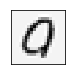

In [6]:
pick_one = np.random.randint(0,5000)
plot_an_image(x[pick_one,:]) #取一行数据
plt.show()

In [7]:
def plot_100_image(x):
    size = int(np.sqrt(x.shape[1])) #图片大小
    
    sample_idx = np.random.choice(np.arange(x.shape[0]), 100)  #随机选100个图片的索引
    sample_images = x[sample_idx, :] # 100*400

    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))

    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape((size, size)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))  
            #绘图函数，画100张图片

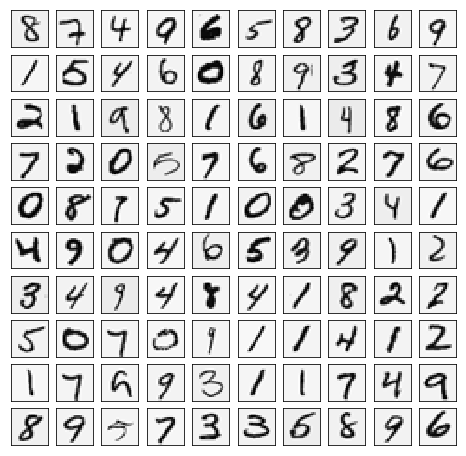

In [8]:
plot_100_image(x)
plt.show()

In [9]:
#定义参数
m = x.shape[0]
n = x.shape[1]
theta = np.zeros(n+1)
reg = 1 # 正则 超参数
x = np.column_stack((np.ones(m),x)) 

In [10]:
print(x.shape)
print(y.shape)
print(theta.shape)

(5000, 401)
(5000,)
(401,)


In [11]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [12]:
def h_function(theta,x):
    return sigmoid(x @ theta)

### regularized cost（正则化代价函数）
$$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}+\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$$

In [13]:
# theta(n+1,)
# x (m,n+1)
def cost_function(theta,x,y,reg):
    first = -y * np.log(h_function(theta,x)) #(m,1)
    second = (1 - y) * np.log(1 - h_function(theta,x)) #(m,1)
    regular = reg / (2 * m) * np.sum(np.power(theta[1:n+1],2)) #从theta1 开始 
    jval = np.sum(first - second) / m + regular
    return jval

In [14]:
cost_function(theta,x,y,reg)

-17.051420641774662

如果我们要使用梯度下降法令这个代价函数最小化，因为我们未对${{\theta }_{0}}$ 进行正则化，所以梯度下降算法将分两种情形：
\begin{align}
  & Repeat\text{ }until\text{ }convergence\text{ }\!\!\{\!\!\text{ } \\ 
 & \text{     }{{\theta }_{0}}:={{\theta }_{0}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{_{0}}^{(i)}} \\ 
 & \text{     }{{\theta }_{j}}:={{\theta }_{j}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{j}^{(i)}}+\frac{\lambda }{m}{{\theta }_{j}} \\ 
 & \text{          }\!\!\}\!\!\text{ } \\ 
 & Repeat \\ 
\end{align}

对上面的算法中 j=1,2,...,n 时的更新式子进行调整可得： 
${{\theta }_{j}}:={{\theta }_{j}}(1-a\frac{\lambda }{m})-a\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{j}^{(i)}}$

In [15]:
#delta (m,1)
# x(m,n+1)
# y(m,)
def gradient(theta,x,y,reg):
    theta = np.matrix(theta) #(1,n+1)
    y = np.matrix(y)#(1,m)
    
    delta = sigmoid(x @ theta.T) - y.T #(m,1)
    
    new_theta = x.T @ delta / m + reg / m * theta.T
    
    new_theta[0,0] = delta.T @ x[:,0] / m #thata0 单独计算
   
    return np.array(new_theta)

In [16]:
test = gradient(theta,x,y,reg)

In [17]:
test.shape,test

((401, 1), array([[-5.00000000e+00],
        [ 0.00000000e+00],
        [-2.71480120e-07],
        [ 2.32894093e-06],
        [ 9.81812364e-06],
        [ 1.18945364e-05],
        [-1.67647949e-04],
        [-3.50514798e-04],
        [-2.42273365e-05],
        [ 7.01455287e-05],
        [ 6.77499746e-04],
        [ 1.97325664e-03],
        [ 3.15902809e-03],
        [ 4.09572057e-03],
        [ 3.13993466e-03],
        [ 1.16280921e-03],
        [ 1.42120275e-04],
        [-6.90103486e-06],
        [ 1.21246535e-05],
        [-4.87642974e-07],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 2.68348312e-06],
        [-2.61429416e-05],
        [-4.84781693e-05],
        [ 1.03519679e-04],
        [-5.62462566e-04],
        [-2.58326183e-03],
        [-4.61268517e-03],
        [-4.50548865e-03],
        [-7.74385868e-03],
        [-1.90561252e-02],
        [-3.48183384e-02],
        [-4.20827773e-02],
        [-3.03361535e-02],
        [-1.37871691e-02],
        [-3.233064

In [18]:
from scipy.optimize import minimize
def one_vs_all(x,y,k,reg):
    
    all_theta = np.zeros((k,n+1))
    #依次对每个数字进行单独计算 算出每个数字的theta值
    #将多分类 化为多次二分类
    for i in range(1,k+1):
        new_theta = np.zeros(n+1)
        y_i = np.array([1 if label == i else 0 for label in y]) #(5000,)
        
        fmin = minimize(fun=cost_function,x0=new_theta,args=(x,y_i,reg),method='TNC',jac=gradient)
        all_theta[i-1,:] = fmin.x
    return all_theta

In [19]:
np.unique(y)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [20]:
all_theta = one_vs_all(x,y,10,1)
all_theta

array([[-2.38245511e+00,  0.00000000e+00, -3.25038323e-11, ...,
         2.35345478e-04,  1.64185304e-05,  0.00000000e+00],
       [-3.18393590e+00,  0.00000000e+00, -1.60444369e-06, ...,
         2.12875851e-03, -1.48296744e-04,  0.00000000e+00],
       [-4.79719569e+00,  0.00000000e+00, -3.28420614e-09, ...,
         1.27732637e-03,  1.81688108e-05,  0.00000000e+00],
       ...,
       [-7.98583704e+00,  0.00000000e+00, -7.05651466e-10, ...,
         8.79360627e-03, -6.39507239e-04,  0.00000000e+00],
       [-4.57301152e+00,  0.00000000e+00, -1.86406259e-08, ...,
        -9.75421783e-04, -1.22477984e-03,  0.00000000e+00],
       [-5.40458812e+00,  0.00000000e+00, -1.73517928e-09, ...,
        -2.30740019e-04,  4.91799264e-04,  0.00000000e+00]])

测试

In [21]:
# x (m,n)
def predict_all(x,all_theta):
    
    all_theta = np.matrix(all_theta) #(k,n+1)
    h = sigmoid(x @ all_theta.T)
    h_argmax = np.argmax(h,axis=1)
    #因为索引从0开始 对每个索引加1就得到正确的值
    h_argmax = h_argmax + 1
    
    return h_argmax

In [22]:
y_pred = predict_all(x, all_theta)
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print ('accuracy = {0}%'.format(accuracy * 100))

accuracy = 94.46%


In [23]:
y_pred

matrix([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 7]], dtype=int64)

In [24]:
np.unique(np.array(y_pred)),y_pred.shape

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64), (5000, 1))